<a href="https://colab.research.google.com/github/vhrique/anne_ptbr/blob/main/04a_Exemplo_Serie_Temporal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/vhrique/anne_ptbr/refs/heads/main/data/box-jenkins-gas-furnace.txt')

In [ ]:
df_train = df.iloc[:-100]
df_test = df.iloc[-100:]

In [ ]:
df_mean = df_train.mean()
df_std = df_train.std()

df_train_norm = (df_train - df_mean) / df_std
df_test_norm = (df_test - df_mean) / df_std

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, dataframe, sequence_length=10):
        self.data = dataframe.values
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.sequence_length, :]
        y = self.data[idx+self.sequence_length, :]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [ ]:
sequence_length = 10

train_dataset = TimeSeriesDataset(df_train, sequence_length)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TimeSeriesDataset(df_test, sequence_length)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=10):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_x, batch_y in dataloader:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch_x)

            # Compute the loss
            loss = criterion(outputs, batch_y)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate the loss for reporting
            running_loss += loss.item() * batch_x.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    print('Finished Training')

In [ ]:
def evaluate_model(model, dataloader, criterion):
    model.eval()  # Set the model to evaluation mode
    eval_loss = 0.0
    all_outputs = []
    all_labels = []
    with torch.no_grad():  # Disable gradient computation during evaluation
        for batch_x, batch_y in dataloader:
            # Forward pass
            outputs = model(batch_x)

            # Compute the loss
            loss = criterion(outputs, batch_y)

            # Accumulate the loss
            eval_loss += loss.item() * batch_x.size(0)

            all_outputs.extend(outputs.detach().tolist())
            all_labels.extend(batch_y.tolist())
    avg_loss = eval_loss / len(dataloader.dataset)
    print(f'Evaluation Loss: {avg_loss:.4f}')

    all_outputs = np.array(all_outputs)
    all_labels = np.array(all_labels)
    return all_outputs, all_labels

In [ ]:
class TimeSeriesMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TimeSeriesMLP, self).__init__()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
num_features = df_train.shape[1]
input_size = sequence_length * num_features
hidden_size = 64
output_size = num_features

model = TimeSeriesMLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 200
train_model(model, train_loader, criterion, optimizer, num_epochs)
all_outputs, all_labels = evaluate_model(model, test_loader, criterion)

Epoch [10/200], Loss: 8.5263
Epoch [20/200], Loss: 3.5799
Epoch [30/200], Loss: 3.0291
Epoch [40/200], Loss: 2.5829
Epoch [50/200], Loss: 2.2374
Epoch [60/200], Loss: 1.9398
Epoch [70/200], Loss: 1.6916
Epoch [80/200], Loss: 1.5445
Epoch [90/200], Loss: 1.3464
Epoch [100/200], Loss: 1.2310
Epoch [110/200], Loss: 1.1310
Epoch [120/200], Loss: 1.0278
Epoch [130/200], Loss: 0.9562
Epoch [140/200], Loss: 0.8940
Epoch [150/200], Loss: 0.8461
Epoch [160/200], Loss: 0.8088
Epoch [170/200], Loss: 0.7839
Epoch [180/200], Loss: 0.7302
Epoch [190/200], Loss: 0.7110
Epoch [200/200], Loss: 0.6793
Finished Training
Evaluation Loss: 1.5189


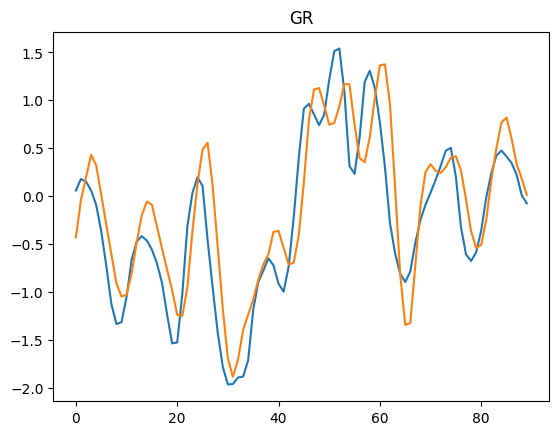

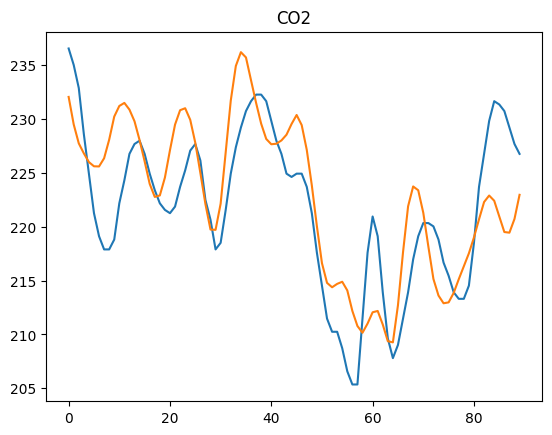

In [ ]:
outputs = all_outputs * df_std.to_numpy() + df_mean.to_numpy()
labels = all_labels * df_std.to_numpy() + df_mean.to_numpy()

for i in range(2):
    plt.plot(labels[:,i])
    plt.plot(outputs[:,i])
    plt.title(df_std.index[i])
    plt.show()

In [ ]:
class TimeSeriesLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(TimeSeriesLSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state and cell state (h0, c0)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate through LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Take only the last output for the fully connected layer
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
hidden_size = 64
output_size = num_features
num_layers = 1

model = TimeSeriesLSTM(input_size=num_features, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 200
train_model(model, train_loader, criterion, optimizer, num_epochs)
all_outputs, all_labels = evaluate_model(model, test_loader, criterion)

Epoch [10/200], Loss: 364.3975
Epoch [20/200], Loss: 41.7310
Epoch [30/200], Loss: 6.6758
Epoch [40/200], Loss: 5.4967
Epoch [50/200], Loss: 5.5133
Epoch [60/200], Loss: 5.4899
Epoch [70/200], Loss: 5.4878
Epoch [80/200], Loss: 5.4754
Epoch [90/200], Loss: 5.4887
Epoch [100/200], Loss: 5.4724
Epoch [110/200], Loss: 3.7402
Epoch [120/200], Loss: 2.2687
Epoch [130/200], Loss: 1.4654
Epoch [140/200], Loss: 1.1905
Epoch [150/200], Loss: 0.8976
Epoch [160/200], Loss: 0.8136
Epoch [170/200], Loss: 0.6126
Epoch [180/200], Loss: 0.5036
Epoch [190/200], Loss: 0.4383
Epoch [200/200], Loss: 0.3375
Finished Training
Evaluation Loss: 0.6248


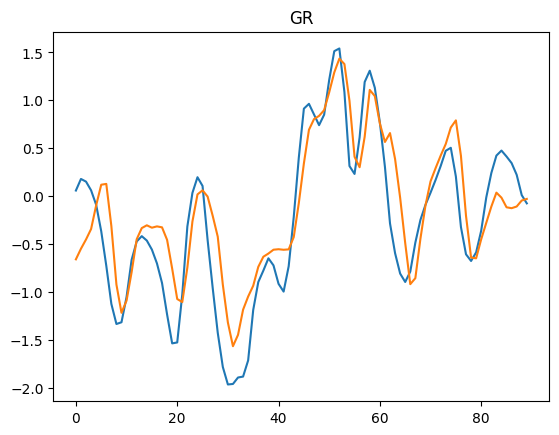

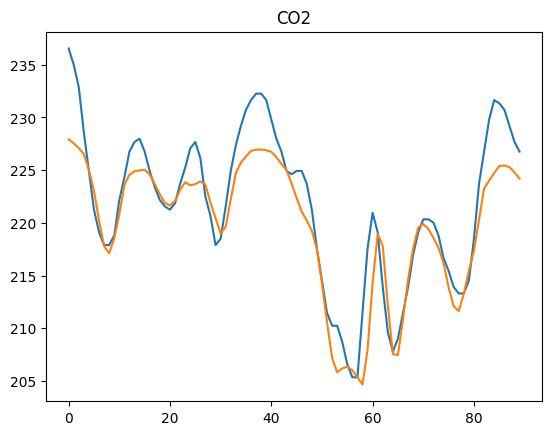

In [ ]:
outputs = all_outputs * df_std.to_numpy() + df_mean.to_numpy()
labels = all_labels * df_std.to_numpy() + df_mean.to_numpy()

for i in range(2):
    plt.plot(labels[:,i])
    plt.plot(outputs[:,i])
    plt.title(df_std.index[i])
    plt.show()